In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile

# sns.set(style="dark")


# path data
DATA_PATH = "../ESG/"
print(os.listdir(DATA_PATH))

# accessible markets
accessible_markets = pd.read_excel(DATA_PATH + "Book1.xlsx").to_numpy().flatten()


# import data
esg_light = "EUESGMANUFACTURER-LIGHT.zip"
esg_light_data = pd.DataFrame()

with zipfile.ZipFile(DATA_PATH + esg_light, "r") as z:
    for filename in z.namelist():
        if filename.endswith(".csv"):
            with z.open(filename) as f:
                esg_light_data = pd.read_csv(f)

print(esg_light_data.shape)
display(esg_light_data.head(3))

['Book1.xlsx', 'data.csv', 'esg_data.csv', 'EUESGMANUFACTURER-LIGHT.zip', 'EUESGMANUFACTURER.zip', 'img_8funds.pdf', 'img_8funds.png', 'img_max_esg_funds.pdf', 'img_max_esg_funds.png', 'img_neutral_esg_funds.pdf', 'img_not_esg_funds.pdf', 'max_esg.tex', 'README.md']
(30157, 22)


,swissValorNumber,ISIN,ISIN_BC,FISN,issuerSIXCompanyKey,LEI,companyDomicile,companyDomicileISO,companyLongName,fundManagerSIXCompanyKey,...,ESGValidFrom,ESGDeliveryDate,ESGActivity,ESGClassification,ESGFactor,ESGFactorProviderId,ESGFactorAmountLastYear,ESGFactorAmountLastYearUnit,ESGClassSymbol,ESGFactorDate
0,28101647,CH0281016474,CH0281016474_393,Von Fd PenInYd/Ut Cl-A CHF,693053,5493005ZZWAG5GH0G736,Switzerland,CH,Vontobel Fund (CH) - Pension Invest Yield,552303.0,...,2024-02-01,2024-02-02,"Data Set, Manufacturer and Product information",EET Data Set Information,00010_EET_Version,00010,1.11,NaN,NaN,NaN
1,28101647,CH0281016474,CH0281016474_393,Von Fd PenInYd/Ut Cl-A CHF,693053,5493005ZZWAG5GH0G736,Switzerland,CH,Vontobel Fund (CH) - Pension Invest Yield,552303.0,...,2024-02-01,2024-02-02,"Data Set, Manufacturer and Product information",EET Data Set Information,00060_EET_Data_Reporting_SFDR_Pre_Contractual,00060,NaN,NaN,ESG3-2 : No,NaN
2,28101647,CH0281016474,CH0281016474_393,Von Fd PenInYd/Ut Cl-A CHF,693053,5493005ZZWAG5GH0G736,Switzerland,CH,Vontobel Fund (CH) - Pension Invest Yield,552303.0,...,2024-02-01,2024-02-02,"Data Set, Manufacturer and Product information",EET Data Set Information,00070_EET_Data_Reporting_SFDR_Periodic,00070,NaN,NaN,ESG3-2 : No,NaN


In [43]:
%load_ext autoreload
%autoreload 2

# import class for API
from financial_data_api import FinancialDataAPI
from financial_data_api import get_data, get_financial_ts, get_instrument_name, get_markets_correct_currency, get_accessible_markets_bc

print(os.listdir("../SIXWebAPI"))
dir = "../SIXWebAPI/CH52991-hackathon7"

# initialize class
fin_cursor = FinancialDataAPI(dir)

# time span
start_date = "2017-01-01"
end_date = "2024-03-12"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['CH52991-hackathon1', 'CH52991-hackathon10', 'CH52991-hackathon2', 'CH52991-hackathon3', 'CH52991-hackathon4', 'CH52991-hackathon5', 'CH52991-hackathon6', 'CH52991-hackathon7', 'CH52991-hackathon8', 'CH52991-hackathon9', 'README.md']


In [44]:
from data_pure import get_clean_data_esg

export = False
if export:
    esg_criterion = get_clean_data_esg(esg_light_data)
    esg_criterion.to_csv(DATA_PATH + "esg_data.csv")
esg_criterion = pd.read_csv(DATA_PATH + "esg_data.csv")
esg_criterion[esg_criterion["ProductType"] >= 8].head(10)

,Unnamed: 0,ISIN,ProductType,Environment,Social,Governance
0,0,CH0281016474,8.0,0.0,0.2,0.0
1,1,CH0281016656,8.0,0.0,0.2,0.0
2,2,CH0281016938,8.0,0.0,0.2,0.0
3,3,CH0281017506,8.0,0.0,0.2,0.0
4,4,CH0281018538,8.0,0.0,0.2,0.0
5,5,CH0281018728,8.0,0.0,0.2,0.0
6,6,CH0294813131,8.0,0.0,0.2,0.0
7,7,CH0294813149,8.0,0.0,0.2,0.0
8,8,CH0297178714,8.0,0.0,0.0,0.0
9,9,CH0297178755,8.0,0.0,0.0,0.0


In [45]:
unique_isin_country = ["CH0281016474", "CH0281017506", "CH0294813131"]
markets = get_accessible_markets_bc(fin_cursor, "ISIN", unique_isin_country, accessible_markets)
markets

[[200, 2020, 2021, 3089, 3233, 3520],
 [200, 2020, 2021, 3089, 3233, 3520],
 [200, 2020, 2021, 3089, 3233, 3520]]

In [46]:
def create_data(unique_isin_country, markets):
    data_plot = pd.DataFrame(columns=["date", "close_price", "fund_name", "isin_bc"])
    for i, instrument in enumerate(unique_isin_country):
        temp = pd.DataFrame(
            get_financial_ts(
                fin_cursor.endOfDayHistory(
                    "ISIN_BC", [instrument + f"_{markets[i][0]}"], start_date, end_date
                )["data"]["listings"]
            )
        ).T
        temp = temp.rename(columns=dict(zip(temp.columns, data_plot.columns[:-1])))
        temp["isin_bc"] = instrument + f"_{markets[i][0]}"
        data_plot = pd.concat((data_plot, temp))
    return data_plot


data_plot = create_data(unique_isin_country, markets)

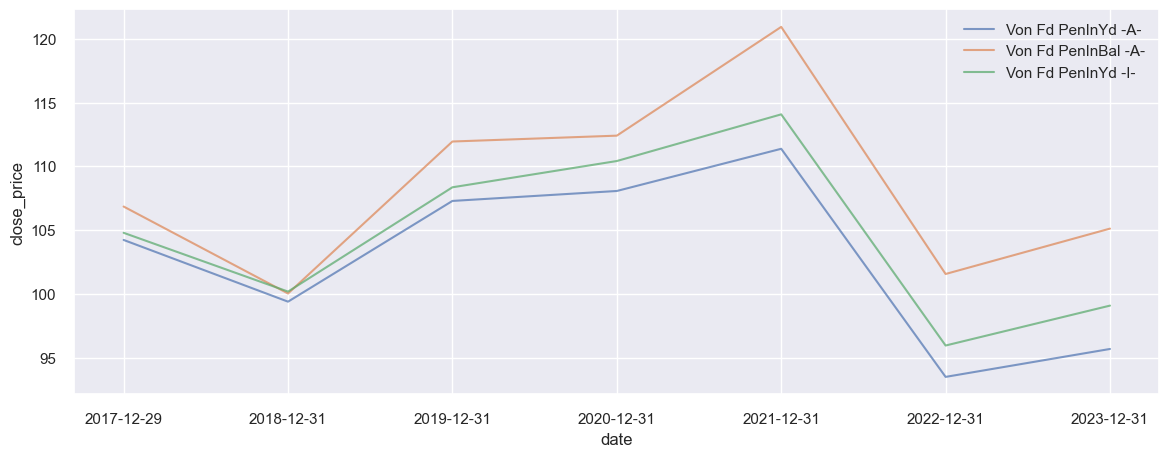

In [47]:
plt.figure(figsize=(14, 5))

sns.lineplot(
    data=data_plot,
    x="date",
    y="close_price",
    hue="fund_name",
    alpha=0.7,
)

plt.legend(loc="best")
plt.grid(True)
plt.show()

In [48]:
def normalize(x):
    return x / x.iloc[0] * 100


data_plot = data_plot.sort_values(["isin_bc", "date"])
data_plot["normalized_close_price"] = data_plot.groupby("isin_bc")[
    "close_price"
].transform(normalize)

data_plot["date"] = pd.to_datetime(data_plot["date"])
data_plot[data_plot["date"] <= pd.to_datetime("2024-01-01")].tail(8)
data_plot.groupby("isin_bc").apply(lambda x: x)

C:\Users\marti\AppData\Local\Temp\ipykernel_10236\3573137822.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_plot.groupby("isin_bc").apply(lambda x: x)


date close_price            fund_name  \
isin_bc                                                          
CH0281016474_200 0 2017-12-29      104.23   Von Fd PenInYd -A-   
                 1 2018-12-31       99.39   Von Fd PenInYd -A-   
                 2 2019-12-31      107.29   Von Fd PenInYd -A-   
                 3 2020-12-31      108.07   Von Fd PenInYd -A-   
                 4 2021-12-31      111.38   Von Fd PenInYd -A-   
                 5 2022-12-31       93.49   Von Fd PenInYd -A-   
                 6 2023-12-31       95.68   Von Fd PenInYd -A-   
CH0281017506_200 0 2017-12-29      106.85  Von Fd PenInBal -A-   
                 1 2018-12-31      100.03  Von Fd PenInBal -A-   
                 2 2019-12-31      111.95  Von Fd PenInBal -A-   
                 3 2020-12-31      112.41  Von Fd PenInBal -A-   
                 4 2021-12-31      120.94  Von Fd PenInBal -A-   
                 5 2022-12-31      101.56  Von Fd PenInBal -A-   
                 6 2023-12-31      105.12  Von Fd PenInBal -A-   
CH0294813131_200 0 2017-12-29      104.79   Von Fd PenInYd -I-   
                 1 2018-12-31      100.18   Von Fd PenInYd -I-   
                 2 2019-12-31      108.36   Von Fd PenInYd -I-   
                 3 2020-12-31      110.42   Von Fd PenInYd -I-   
                 4 2021-12-31      114.08   Von Fd PenInYd -I-   
                 5 2022-12-31       95.95   Von Fd PenInYd -I-   
                 6 2023-12-31       99.08   Von Fd PenInYd -I-   

                             isin_bc normalized_close_price  
isin_bc                                                      
CH0281016474_200 0  CH0281016474_200                  100.0  
                 1  CH0281016474_200              95.356423  
                 2  CH0281016474_200             102.935815  
                 3  CH0281016474_200              103.68416  
                 4  CH0281016474_200             106.859829  
                 5  CH0281016474_200              89.695865  
                 6  CH0281016474_200              91.796987  
CH0281017506_200 0  CH0281017506_200                  100.0  
                 1  CH0281017506_200               93.61722  
                 2  CH0281017506_200             104.773046  
                 3  CH0281017506_200             105.203556  
                 4  CH0281017506_200              113.18671  
                 5  CH0281017506_200              95.049134  
                 6  CH0281017506_200              98.380908  
CH0294813131_200 0  CH0294813131_200                  100.0  
                 1  CH0294813131_200              95.600725  
                 2  CH0294813131_200             103.406814  
                 3  CH0294813131_200              105.37265  
                 4  CH0294813131_200              108.86535  
                 5  CH0294813131_200              91.564081  
                 6  CH0294813131_200              94.551007

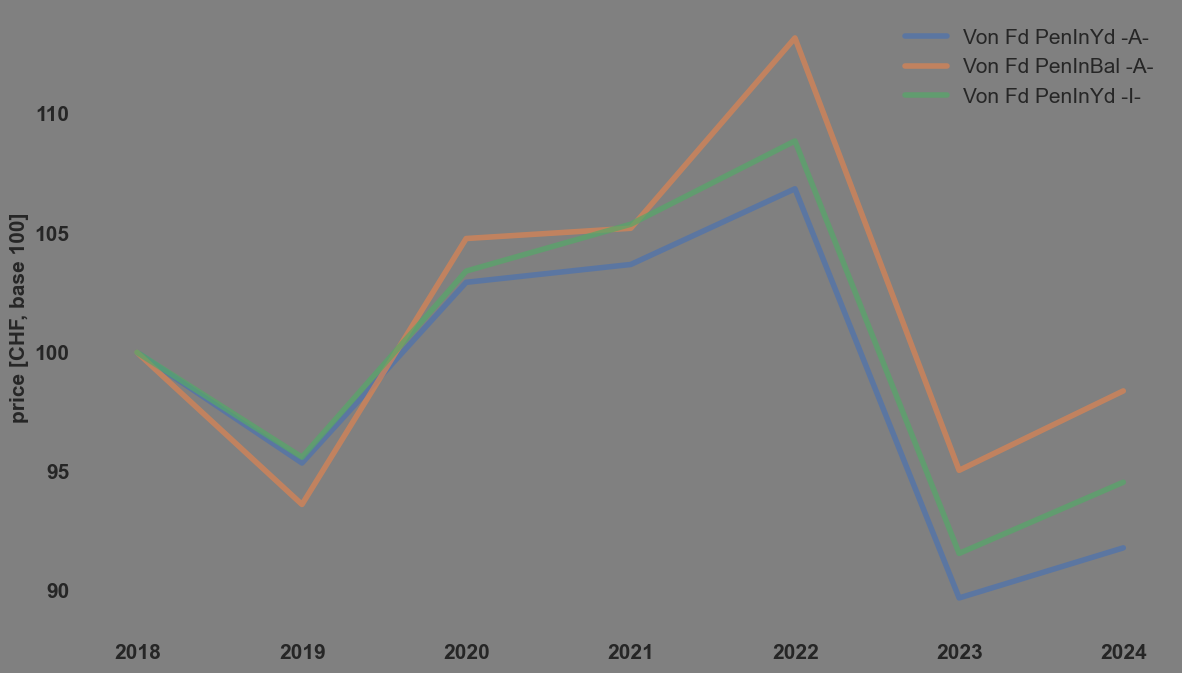

In [80]:
# sns.set(style="dark")
plt.figure(figsize=(14, 8), facecolor="grey")
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_facecolor('grey')

fig = sns.lineplot(
    data=data_plot,
    x="date",
    y="normalized_close_price",
    hue="fund_name",
    alpha=0.7,
    linewidth=4
)
plt.xlabel("")
plt.ylabel("price [CHF, base 100]", fontsize=15, weight='bold')
plt.legend(loc="best", fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
for label in ax.get_xticklabels():
    label.set_weight("bold")
for label in ax.get_yticklabels():
    label.set_weight("bold")
# plt.savefig(
#     DATA_PATH + "img_8funds.png",
#     bbox_inches="tight"
# )
plt.show()

In [9]:
def get_stats(data_plot):
    data_plot["annual_return"] = (
        data_plot.groupby("isin_bc")["close_price"].pct_change(1) * 100
    )
    print("average annual return")
    print(data_plot.groupby("isin_bc")["annual_return"].mean())

    print("annual volatility")
    print(data_plot.groupby("isin_bc")["annual_return"].std())

    print("performance")
    print(
        data_plot.groupby("isin_bc")["close_price"].apply(
            lambda x: x.pct_change().sum() * 100
        )
    )

get_stats(data_plot)

average annual return
isin_bc
CH0281016474_200   -1.104149
CH0281017506_200    0.168946
CH0294813131_200   -0.608088
Name: annual_return, dtype: object
annual volatility
isin_bc
CH0281016474_200     8.376337
CH0281017506_200    10.093482
CH0294813131_200     8.504308
Name: annual_return, dtype: float64
performance
isin_bc
CH0281016474_200   -6.624893
CH0281017506_200    1.013678
CH0294813131_200   -3.648525
Name: close_price, dtype: float64


C:\Users\marti\AppData\Local\Temp\ipykernel_10236\600252371.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda x: x.pct_change().sum() * 100


In [10]:
from tabulate import tabulate

data = {
    'ISIN': ['CH0281016474_200', 'CH0281017506_200', 'CH0294813131_200'],
    'Annual Return (%)': [-1.104149, 0.168946, -0.608088],
    'Annual Volatility (%)': [8.376337, 10.093482, 8.504308],
    'Performance (%)': [-6.624893, 1.013678, -3.648525]
}

df = pd.DataFrame(data)

print(tabulate(df, headers='keys', tablefmt='psql', showindex=False))

+------------------+---------------------+-------------------------+-------------------+
| ISIN             |   Annual Return (%) |   Annual Volatility (%) |   Performance (%) |
|------------------+---------------------+-------------------------+-------------------|
| CH0281016474_200 |           -1.10415  |                 8.37634 |          -6.62489 |
| CH0281017506_200 |            0.168946 |                10.0935  |           1.01368 |
| CH0294813131_200 |           -0.608088 |                 8.50431 |          -3.64852 |
+------------------+---------------------+-------------------------+-------------------+


In [11]:
html_table = tabulate(df, headers='keys', tablefmt='html')
html_table = html_table.replace('<table>', '<table style="background-color: white;">')
styled_df = df.style.set_table_styles(
    [{
        'selector': 'table',
        'props': [
           ('background-color', 'white')
        ]
    }]
)

styled_df

,ISIN,Annual Return (%),Annual Volatility (%),Performance (%)
0,CH0281016474_200,-1.104149,8.376337,-6.624893
1,CH0281017506_200,0.168946,10.093482,1.013678
2,CH0294813131_200,-0.608088,8.504308,-3.648525


In [12]:
quantiles_env = np.quantile(esg_criterion["Environment"], [0.3, 0.6, 0.9])
quantiles_social = np.quantile(esg_criterion["Social"], [0.3, 0.6, 0.9])
quantiles_gov = np.quantile(esg_criterion["Governance"], [0.3, 0.6, 0.9])
print(quantiles_env)
print(quantiles_social)
print(quantiles_gov)

[0.         0.22380952 0.625     ]
[0.2 0.8 1. ]
[0. 0. 1.]


# "not esg"

In [13]:
not_esg_funds = esg_criterion[
    (esg_criterion["Environment"] <= 0.25) & (esg_criterion["Social"] <= 0.2)
]
not_esg_funds.head(20)

,Unnamed: 0,ISIN,ProductType,Environment,Social,Governance
0,0,CH0281016474,8.0,0.0,0.2,0.0
1,1,CH0281016656,8.0,0.0,0.2,0.0
2,2,CH0281016938,8.0,0.0,0.2,0.0
3,3,CH0281017506,8.0,0.0,0.2,0.0
4,4,CH0281018538,8.0,0.0,0.2,0.0
5,5,CH0281018728,8.0,0.0,0.2,0.0
6,6,CH0294813131,8.0,0.0,0.2,0.0
7,7,CH0294813149,8.0,0.0,0.2,0.0
8,8,CH0297178714,8.0,0.0,0.0,0.0
9,9,CH0297178755,8.0,0.0,0.0,0.0


In [14]:
unique_isin_country = ["CH0311188863", "CH0381682621", "CH0281017506"]
print(unique_isin_country)
markets = get_accessible_markets_bc(
    fin_cursor, "ISIN", unique_isin_country, accessible_markets
)
print(markets)

data_plot = create_data(unique_isin_country, markets)
display(data_plot.head())

data_plot = data_plot.sort_values(["isin_bc", "date"])
data_plot["normalized_close_price"] = data_plot.groupby("isin_bc")[
    "close_price"
].transform(normalize)
display(data_plot.groupby("isin_bc").apply(lambda x: x))

data_plot["date"] = pd.to_datetime(data_plot["date"])
data_plot[data_plot["date"] <= pd.to_datetime("2024-01-01")].tail(8)

['CH0311188863', 'CH0381682621', 'CH0281017506']
[[200, 2020, 2021, 3089, 3233, 3520], [200, 2020, 2021, 3089, 3233, 3520], [200, 2020, 2021, 3089, 3233, 3520]]


,date,close_price,fund_name,isin_bc
0,2017-12-29,137.71,VesSwEMF -A-,CH0311188863_200
1,2018-12-31,117.24,VesSwEMF -A-,CH0311188863_200
2,2019-12-31,157.83,VesSwEMF -A-,CH0311188863_200
3,2020-12-31,158.12,VesSwEMF -A-,CH0311188863_200
4,2021-12-31,183.87,VesSwEMF -A-,CH0311188863_200


C:\Users\marti\AppData\Local\Temp\ipykernel_10236\3984896198.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  display(data_plot.groupby("isin_bc").apply(lambda x: x))


date close_price            fund_name  \
isin_bc                                                           
CH0281017506_200 0  2017-12-29      106.85  Von Fd PenInBal -A-   
                 1  2018-12-31      100.03  Von Fd PenInBal -A-   
                 2  2019-12-31      111.95  Von Fd PenInBal -A-   
                 3  2020-12-31      112.41  Von Fd PenInBal -A-   
                 4  2021-12-31      120.94  Von Fd PenInBal -A-   
                 5  2022-12-31      101.56  Von Fd PenInBal -A-   
                 6  2023-12-31      105.12  Von Fd PenInBal -A-   
CH0311188863_200 0  2017-12-29      137.71         VesSwEMF -A-   
                 1  2018-12-31      117.24         VesSwEMF -A-   
                 2  2019-12-31      157.83         VesSwEMF -A-   
                 3  2020-12-31      158.12         VesSwEMF -A-   
                 4  2021-12-31      183.87         VesSwEMF -A-   
                 5  2022-12-31      155.32         VesSwEMF -A-   
                 6  2023-12-31      168.38         VesSwEMF -A-   
CH0381682621_200 0  2017-12-29      101.09        VESSWEMF -AN-   
                 1  2018-12-31       88.31        VESSWEMF -AN-   
                 2  2019-12-31      119.47        VESSWEMF -AN-   
                 3  2020-12-31      119.99        VESSWEMF -AN-   
                 4  2021-12-31      139.64        VESSWEMF -AN-   
                 5  2022-12-31      117.85        VESSWEMF -AN-   
                 6  2023-12-31      127.86        VESSWEMF -AN-   

                             isin_bc normalized_close_price  
isin_bc                                                      
CH0281017506_200 0  CH0281017506_200                  100.0  
                 1  CH0281017506_200               93.61722  
                 2  CH0281017506_200             104.773046  
                 3  CH0281017506_200             105.203556  
                 4  CH0281017506_200              113.18671  
                 5  CH0281017506_200              95.049134  
                 6  CH0281017506_200              98.380908  
CH0311188863_200 0  CH0311188863_200                  100.0  
                 1  CH0311188863_200               85.13543  
                 2  CH0311188863_200             114.610413  
                 3  CH0311188863_200             114.821001  
                 4  CH0311188863_200             133.519715  
                 5  CH0311188863_200             112.787742  
                 6  CH0311188863_200              122.27144  
CH0381682621_200 0  CH0381682621_200                  100.0  
                 1  CH0381682621_200                87.3578  
                 2  CH0381682621_200             118.181818  
                 3  CH0381682621_200             118.696211  
                 4  CH0381682621_200             138.134336  
                 5  CH0381682621_200             116.579286  
                 6  CH0381682621_200             126.481353

,date,close_price,fund_name,isin_bc,normalized_close_price
6,2023-12-31,168.38,VesSwEMF -A-,CH0311188863_200,122.27144
0,2017-12-29,101.09,VESSWEMF -AN-,CH0381682621_200,100.0
1,2018-12-31,88.31,VESSWEMF -AN-,CH0381682621_200,87.3578
2,2019-12-31,119.47,VESSWEMF -AN-,CH0381682621_200,118.181818
3,2020-12-31,119.99,VESSWEMF -AN-,CH0381682621_200,118.696211
4,2021-12-31,139.64,VESSWEMF -AN-,CH0381682621_200,138.134336
5,2022-12-31,117.85,VESSWEMF -AN-,CH0381682621_200,116.579286
6,2023-12-31,127.86,VESSWEMF -AN-,CH0381682621_200,126.481353


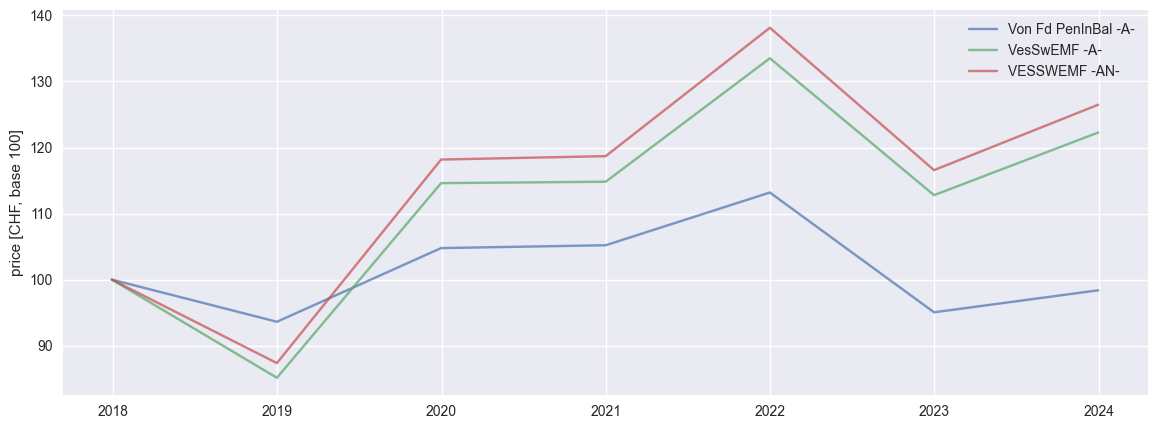

In [15]:
plt.figure(figsize=(14, 5))

sns.lineplot(
    data=data_plot,
    x="date",
    y="normalized_close_price",
    hue="fund_name",
    alpha=0.7,
)
plt.xlabel("")
plt.ylabel("price [CHF, base 100]")
plt.legend(loc="best")
plt.grid(True)
# plt.savefig(
#     DATA_PATH + "img_not_esg_funds.pdf",
#     bbox_inches="tight"
# )
plt.show()

In [16]:
get_stats(data_plot)

average annual return
isin_bc
CH0281017506_200    0.168946
CH0311188863_200    4.851122
CH0381682621_200    5.390608
Name: annual_return, dtype: object
annual volatility
isin_bc
CH0281017506_200    10.093482
CH0311188863_200    19.263568
CH0381682621_200    19.049975
Name: annual_return, dtype: float64
performance
isin_bc
CH0281017506_200     1.013678
CH0311188863_200    29.106733
CH0381682621_200    32.343649
Name: close_price, dtype: float64


C:\Users\marti\AppData\Local\Temp\ipykernel_10236\600252371.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda x: x.pct_change().sum() * 100


In [17]:
from tabulate import tabulate

data = {
    'ISIN': ['CH0281017506_200', 'CH0311188863_200', 'CH0381682621_200'],
    'Annual Return (%)': [0.168946, 4.851122, 5.390608],
    'Annual Volatility (%)': [10.093482, 19.263568, 19.049975],
    'Performance (%)': [1.013678, 29.106733, 32.343649]
}

df = pd.DataFrame(data)

print(tabulate(df, headers='keys', tablefmt='psql', showindex=False))

+------------------+---------------------+-------------------------+-------------------+
| ISIN             |   Annual Return (%) |   Annual Volatility (%) |   Performance (%) |
|------------------+---------------------+-------------------------+-------------------|
| CH0281017506_200 |            0.168946 |                 10.0935 |           1.01368 |
| CH0311188863_200 |            4.85112  |                 19.2636 |          29.1067  |
| CH0381682621_200 |            5.39061  |                 19.05   |          32.3436  |
+------------------+---------------------+-------------------------+-------------------+


# "a bit esg"
[0.         0.22380952 0.625     ]
[0.2 0.8 1. ]
[0. 0. 1.]

In [18]:
neutral_esg_funds = esg_criterion[
    (esg_criterion["Environment"] >= 0.3)
    & (esg_criterion["Environment"] <= 0.7)
    & (esg_criterion["Social"] >= 0.2)
    & (esg_criterion["Social"] <= 0.7)
]
neutral_esg_funds.head(20)

,Unnamed: 0,ISIN,ProductType,Environment,Social,Governance
133,133,US9219361006,8.0,0.327381,0.6,1.0
152,152,FR0000299240,8.0,0.327381,0.6,1.0
161,161,FR0007492665,8.0,0.327381,0.6,1.0
162,162,FR0007492681,8.0,0.327381,0.6,1.0
163,163,FR0007493051,8.0,0.327381,0.6,1.0
170,170,FR0000099939,8.0,0.559524,0.6,0.0
177,177,FR0000290124,8.0,0.559524,0.6,0.0
179,179,FR0000096695,8.0,0.392857,0.4,0.0
183,183,FR0000097156,8.0,0.559524,0.6,0.0
309,309,DE0008471376,8.0,0.327381,0.6,1.0


In [19]:
unique_isin_country = ["IE0008365516", "IE0008366704", "IE0008366589"]

print(unique_isin_country)
markets = get_accessible_markets_bc(
    fin_cursor, "ISIN", unique_isin_country, accessible_markets
)
print(markets)

data_plot = create_data(unique_isin_country, markets)
display(data_plot.head())

data_plot = data_plot.sort_values(["isin_bc", "date"])
data_plot["normalized_close_price"] = data_plot.groupby("isin_bc")[
    "close_price"
].transform(normalize)
display(data_plot.groupby("isin_bc").apply(lambda x: x))

data_plot["date"] = pd.to_datetime(data_plot["date"])
data_plot[data_plot["date"] <= pd.to_datetime("2024-01-01")].tail(8)

['IE0008365516', 'IE0008366704', 'IE0008366589']
[[200, 2020, 2021, 3089, 3231], [200, 2020, 2021, 3089, 3231], [200, 2020, 2021, 3089, 3234]]


,date,close_price,fund_name,isin_bc
0,2017-12-29,30.74,AXA IM US USD-A-Acc,IE0008365516_200
1,2018-12-31,27.98,AXA IM US USD-A-Acc,IE0008365516_200
2,2019-12-31,35.67,AXA IM US USD-A-Acc,IE0008365516_200
3,2020-12-31,36.49,AXA IM US USD-A-Acc,IE0008365516_200
4,2021-12-31,48.946495,AXA IM US USD-A-Acc,IE0008365516_200


C:\Users\marti\AppData\Local\Temp\ipykernel_10236\407697104.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  display(data_plot.groupby("isin_bc").apply(lambda x: x))


date close_price            fund_name  \
isin_bc                                                           
IE0008365516_200 0  2017-12-29       30.74  AXA IM US USD-A-Acc   
                 1  2018-12-31       27.98  AXA IM US USD-A-Acc   
                 2  2019-12-31       35.67  AXA IM US USD-A-Acc   
                 3  2020-12-31       36.49  AXA IM US USD-A-Acc   
                 4  2021-12-31   48.946495  AXA IM US USD-A-Acc   
                 5  2022-12-31   40.996853  AXA IM US USD-A-Acc   
                 6  2023-12-31   44.799646  AXA IM US USD-A-Acc   
IE0008366589_200 0  2017-12-29       11.22   AXA IM Jap Eqty-A-   
                 1  2018-12-31        9.22   AXA IM Jap Eqty-A-   
                 2  2019-12-31       10.82   AXA IM Jap Eqty-A-   
                 3  2020-12-31       10.51   AXA IM Jap Eqty-A-   
                 4  2021-12-31   10.899571   AXA IM Jap Eqty-A-   
                 5  2022-12-31     8.84073   AXA IM Jap Eqty-A-   
                 6  2023-12-31    9.351871   AXA IM Jap Eqty-A-   
IE0008366704_200 0  2017-12-29       41.72   AXA IM Jp USD-A-Ac   
                 1  2018-12-31       36.88   AXA IM Jp USD-A-Ac   
                 2  2019-12-31       42.58   AXA IM Jp USD-A-Ac   
                 3  2020-12-31       42.24   AXA IM Jp USD-A-Ac   
                 4  2021-12-31   46.513748   AXA IM Jp USD-A-Ac   
                 5  2022-12-31   42.292172   AXA IM Jp USD-A-Ac   
                 6  2023-12-31   39.564744   AXA IM Jp USD-A-Ac   

                             isin_bc normalized_close_price  
isin_bc                                                      
IE0008365516_200 0  IE0008365516_200                  100.0  
                 1  IE0008365516_200               91.02147  
                 2  IE0008365516_200             116.037736  
                 3  IE0008365516_200              118.70527  
                 4  IE0008365516_200             159.227373  
                 5  IE0008365516_200             133.366469  
                 6  IE0008365516_200             145.737298  
IE0008366589_200 0  IE0008366589_200                  100.0  
                 1  IE0008366589_200              82.174688  
                 2  IE0008366589_200              96.434938  
                 3  IE0008366589_200              93.672014  
                 4  IE0008366589_200              97.144128  
                 5  IE0008366589_200              78.794381  
                 6  IE0008366589_200              83.350009  
IE0008366704_200 0  IE0008366704_200                  100.0  
                 1  IE0008366704_200              88.398849  
                 2  IE0008366704_200             102.061361  
                 3  IE0008366704_200             101.246405  
                 4  IE0008366704_200             111.490288  
                 5  IE0008366704_200             101.371457  
                 6  IE0008366704_200              94.833999

,date,close_price,fund_name,isin_bc,normalized_close_price
6,2023-12-31,9.351871,AXA IM Jap Eqty-A-,IE0008366589_200,83.350009
0,2017-12-29,41.72,AXA IM Jp USD-A-Ac,IE0008366704_200,100.0
1,2018-12-31,36.88,AXA IM Jp USD-A-Ac,IE0008366704_200,88.398849
2,2019-12-31,42.58,AXA IM Jp USD-A-Ac,IE0008366704_200,102.061361
3,2020-12-31,42.24,AXA IM Jp USD-A-Ac,IE0008366704_200,101.246405
4,2021-12-31,46.513748,AXA IM Jp USD-A-Ac,IE0008366704_200,111.490288
5,2022-12-31,42.292172,AXA IM Jp USD-A-Ac,IE0008366704_200,101.371457
6,2023-12-31,39.564744,AXA IM Jp USD-A-Ac,IE0008366704_200,94.833999


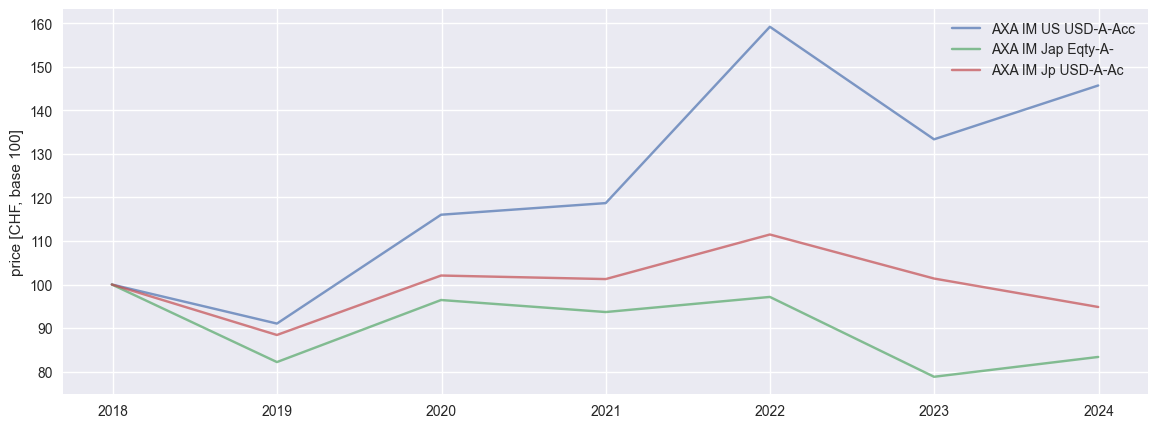

In [20]:
plt.figure(figsize=(14, 5))

sns.lineplot(
    data=data_plot,
    x="date",
    y="normalized_close_price",
    hue="fund_name",
    alpha=0.7,
)
plt.xlabel("")
plt.ylabel("price [CHF, base 100]")
plt.legend(loc="best")
plt.grid(True)
# plt.savefig(
#     DATA_PATH + "img_neutral_esg_funds.pdf",
#     bbox_inches="tight"
# )
plt.show()

In [21]:
get_stats(data_plot)

average annual return
isin_bc
IE0008365516_200    7.995883
IE0008366589_200   -2.122943
IE0008366704_200   -0.391888
Name: annual_return, dtype: object
annual volatility
isin_bc
IE0008365516_200    19.863550
IE0008366589_200    14.170565
IE0008366704_200    10.949966
Name: annual_return, dtype: float64
performance
isin_bc
IE0008365516_200    47.975296
IE0008366589_200   -12.737658
IE0008366704_200    -2.351329
Name: close_price, dtype: float64


C:\Users\marti\AppData\Local\Temp\ipykernel_10236\600252371.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda x: x.pct_change().sum() * 100


In [22]:
from tabulate import tabulate

data = {
    'ISIN': ['IE0008365516_200', 'IE0008366589_200', 'IE0008366704_200'],
    'Annual Return (%)': [7.995883, -2.122943, -0.391888],
    'Annual Volatility (%)': [19.863550, 14.170565, 10.949966],
    'Performance (%)': [47.975296, -12.737658, -2.351329]
}

df = pd.DataFrame(data)

print(tabulate(df, headers='keys', tablefmt='psql', showindex=False))

+------------------+---------------------+-------------------------+-------------------+
| ISIN             |   Annual Return (%) |   Annual Volatility (%) |   Performance (%) |
|------------------+---------------------+-------------------------+-------------------|
| IE0008365516_200 |            7.99588  |                 19.8636 |          47.9753  |
| IE0008366589_200 |           -2.12294  |                 14.1706 |         -12.7377  |
| IE0008366704_200 |           -0.391888 |                 10.95   |          -2.35133 |
+------------------+---------------------+-------------------------+-------------------+


# "very esg"

In [23]:
max_esg_funds = esg_criterion[
    (esg_criterion["Environment"] >= 0.7)
    & (esg_criterion["Social"] >= 0.7)
]
max_esg_funds.head(20)

,Unnamed: 0,ISIN,ProductType,Environment,Social,Governance
295,295,DE0008478082,9.0,0.87500,1.0,1.0
318,318,IE0008042461,8.0,0.85119,1.0,0.5
320,320,IE0008005567,8.0,0.85119,1.0,0.5
327,327,IE0008004719,8.0,0.85119,1.0,0.5
334,334,IE0004329607,8.0,0.85119,1.0,0.5
335,335,IE0008040424,8.0,0.85119,1.0,0.5
336,336,IE0004329375,8.0,0.85119,1.0,0.5
337,337,IE0004329268,8.0,0.85119,1.0,0.5
338,338,IE0004904748,8.0,0.85119,1.0,0.5
339,339,IE0004832923,8.0,0.85119,1.0,0.5


In [24]:
unique_isin_country = ["LI0321177912", "LI0253998061", "LI0306626206"]

print(unique_isin_country)
markets = get_accessible_markets_bc(
    fin_cursor, "ISIN", unique_isin_country, accessible_markets
)
print(markets)

data_plot = create_data(unique_isin_country, markets)
display(data_plot.head())

data_plot = data_plot.sort_values(["isin_bc", "date"])
data_plot["normalized_close_price"] = data_plot.groupby("isin_bc")[
    "close_price"
].transform(normalize)
display(data_plot.groupby("isin_bc").apply(lambda x: x))

data_plot["date"] = pd.to_datetime(data_plot["date"])
data_plot[data_plot["date"] <= pd.to_datetime("2024-01-01")].tail(8)

['LI0321177912', 'LI0253998061', 'LI0306626206']
[[200, 2020, 2021, 2810, 3230], [200, 2020, 2021, 2810, 3230], [200, 2020, 2021, 2810, 3233]]


,date,close_price,fund_name,isin_bc
0,2017-12-29,1415.03,ACATISFAIRVAL EUR-V,LI0321177912_200
1,2018-12-31,1242.13,ACATISFAIRVAL EUR-V,LI0321177912_200
2,2019-12-31,1464.6,ACATISFAIRVAL EUR-V,LI0321177912_200
3,2020-12-31,1583.92,ACATISFAIRVAL EUR-V,LI0321177912_200
4,2021-12-31,1846.2846,ACATISFAIRVAL EUR-V,LI0321177912_200


C:\Users\marti\AppData\Local\Temp\ipykernel_10236\2981188315.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  display(data_plot.groupby("isin_bc").apply(lambda x: x))


date  close_price            fund_name  \
isin_bc                                                            
LI0253998061_200 0  2017-12-29      1439.99   ACATIS FAVAL EUR-I   
                 1  2018-12-31      1267.66   ACATIS FAVAL EUR-I   
                 2  2019-12-31       1497.1   ACATIS FAVAL EUR-I   
                 3  2020-12-31      1639.99   ACATIS FAVAL EUR-I   
                 4  2021-12-31  1903.469719   ACATIS FAVAL EUR-I   
                 5  2022-12-31  1316.902818   ACATIS FAVAL EUR-I   
                 6  2023-12-31  1420.051671   ACATIS FAVAL EUR-I   
LI0306626206_200 0  2017-12-29      1174.19  ACATIS FAIR V CHF-I   
                 1  2018-12-31      1021.25  ACATIS FAIR V CHF-I   
                 2  2019-12-31      1205.88  ACATIS FAIR V CHF-I   
                 3  2020-12-31      1362.14  ACATIS FAIR V CHF-I   
                 4  2021-12-31      1554.28  ACATIS FAIR V CHF-I   
                 5  2022-12-31      1045.92  ACATIS FAIR V CHF-I   
                 6  2023-12-31      1169.37  ACATIS FAIR V CHF-I   
LI0321177912_200 0  2017-12-29      1415.03  ACATISFAIRVAL EUR-V   
                 1  2018-12-31      1242.13  ACATISFAIRVAL EUR-V   
                 2  2019-12-31       1464.6  ACATISFAIRVAL EUR-V   
                 3  2020-12-31      1583.92  ACATISFAIRVAL EUR-V   
                 4  2021-12-31    1846.2846  ACATISFAIRVAL EUR-V   
                 5  2022-12-31  1228.990145  ACATISFAIRVAL EUR-V   
                 6  2023-12-31  1234.781055  ACATISFAIRVAL EUR-V   

                             isin_bc normalized_close_price  
isin_bc                                                      
LI0253998061_200 0  LI0253998061_200                  100.0  
                 1  LI0253998061_200              88.032556  
                 2  LI0253998061_200                103.966  
                 3  LI0253998061_200             113.888985  
                 4  LI0253998061_200             132.186315  
                 5  LI0253998061_200               91.45222  
                 6  LI0253998061_200              98.615384  
LI0306626206_200 0  LI0306626206_200                  100.0  
                 1  LI0306626206_200              86.974851  
                 2  LI0306626206_200             102.698882  
                 3  LI0306626206_200             116.006779  
                 4  LI0306626206_200               132.3704  
                 5  LI0306626206_200              89.075874  
                 6  LI0306626206_200              99.589504  
LI0321177912_200 0  LI0321177912_200                  100.0  
                 1  LI0321177912_200              87.781178  
                 2  LI0321177912_200             103.503106  
                 3  LI0321177912_200             111.935436  
                 4  LI0321177912_200             130.476711  
                 5  LI0321177912_200              86.852586  
                 6  LI0321177912_200              87.261829

,date,close_price,fund_name,isin_bc,normalized_close_price
6,2023-12-31,1169.37,ACATIS FAIR V CHF-I,LI0306626206_200,99.589504
0,2017-12-29,1415.03,ACATISFAIRVAL EUR-V,LI0321177912_200,100.0
1,2018-12-31,1242.13,ACATISFAIRVAL EUR-V,LI0321177912_200,87.781178
2,2019-12-31,1464.6,ACATISFAIRVAL EUR-V,LI0321177912_200,103.503106
3,2020-12-31,1583.92,ACATISFAIRVAL EUR-V,LI0321177912_200,111.935436
4,2021-12-31,1846.2846,ACATISFAIRVAL EUR-V,LI0321177912_200,130.476711
5,2022-12-31,1228.990145,ACATISFAIRVAL EUR-V,LI0321177912_200,86.852586
6,2023-12-31,1234.781055,ACATISFAIRVAL EUR-V,LI0321177912_200,87.261829


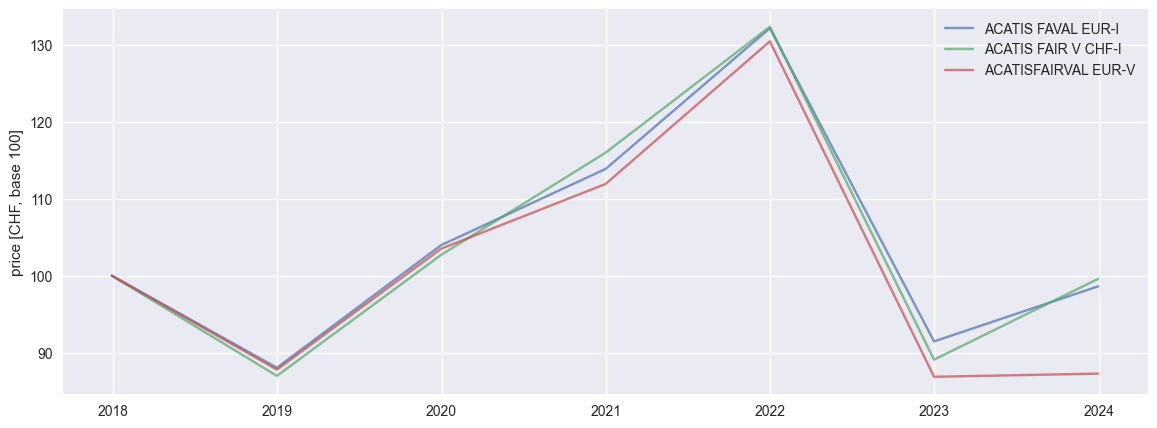

In [26]:
plt.figure(figsize=(14, 5))

sns.lineplot(
    data=data_plot,
    x="date",
    y="normalized_close_price",
    hue="fund_name",
    alpha=0.7,
)
plt.xlabel("")
plt.ylabel("price [CHF, base 100]")
plt.legend(loc="best")
plt.grid(True)
plt.savefig(
    DATA_PATH + "img_max_esg_funds.png",
    bbox_inches="tight"
)
plt.show()

In [56]:
get_stats(data_plot)

average annual return
isin_bc
LI0253998061_200    1.459908
LI0306626206_200    1.868916
LI0321177912_200   -0.426748
Name: annual_return, dtype: object
annual volatility
isin_bc
LI0253998061_200    19.069297
LI0306626206_200    20.255830
LI0321177912_200    19.635770
Name: annual_return, dtype: float64
performance
isin_bc
LI0253998061_200     8.759451
LI0306626206_200    11.213493
LI0321177912_200    -2.560488
Name: close_price, dtype: float64


C:\Users\marti\AppData\Local\Temp\ipykernel_35784\600252371.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda x: x.pct_change().sum() * 100


In [57]:
from tabulate import tabulate

data = {
    'ISIN': ['LI0253998061_200', 'LI0306626206_200', 'LI0321177912_200'],
    'Annual Return (%)': [1.459908, 1.868916, -0.426748],
    'Annual Volatility (%)': [19.069297, 20.255830, 19.635770],
    'Performance (%)': [8.759451, 11.213493, -2.560488]
}

df = pd.DataFrame(data)

print(tabulate(df, headers='keys', tablefmt='psql', showindex=False))

+------------------+---------------------+-------------------------+-------------------+
| ISIN             |   Annual Return (%) |   Annual Volatility (%) |   Performance (%) |
|------------------+---------------------+-------------------------+-------------------|
| LI0253998061_200 |            1.45991  |                 19.0693 |           8.75945 |
| LI0306626206_200 |            1.86892  |                 20.2558 |          11.2135  |
| LI0321177912_200 |           -0.426748 |                 19.6358 |          -2.56049 |
+------------------+---------------------+-------------------------+-------------------+


In [58]:
# # building the DataFrame

# data = {
#     'ISIN': ['LI0253998061_200', 'LI0306626206_200', 'LI0321177912_200'],
#     'Annual Return (\%)': [1.459908, 1.868916, -0.426748],
#     'Annual Volatility (\%)': [19.069297, 20.255830, 19.635770],
#     'Performance (\%)': [8.759451, 11.213493, -2.560488]
# }

# df = pd.DataFrame(data)

# # convert DataFrame to LaTeX

# latex_table = df.to_latex(index=False)

# # add document structure around the table

# begin_document = r'''
# \documentclass{article}
# \begin{document}
# '''

# end_document = r'''
# \end{document}
# '''

# latex_document = begin_document + latex_table + end_document

# # write the result to the tex file

# with open(DATA_PATH + "max_esg.tex", 'w') as tf:
#     tf.write(latex_document)

# import os
# os.system(f"pdflatex {DATA_PATH}max_esg.tex")